# Challenge 2 - Recommendation engine for Prime Video

Today, videos shown to new users on Prime Video’s home page are manually chosen. You need to implement a recommendation engine to increase the conversation rate.

## Business Questions

1- Classify each video into the following buckets:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Hot" - means trending up. These videos are candidates to be shown. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Everything else" - these videos won't be shown. <br>
2- What are the main characteristics of the "hot videos"?<br>
3- After having identified the characteristics of the hot videos, how would you use this information from a product standpoint <br>

In the following notebooks, I will explore the available data and try to provide data-driven answers to the above business questions.

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Read in the data

The data provided is in CSV format and in two separate files as summarised below:

File 1: video_count<br>
Columns: <br>
*video_id*: unique video id<br>
*count*: total count of views for the specific video_id on the specific date <br>
*date*: the date that these views occurred<br>


File 2: video_features<br> 
Columns: <br>
*video_id*: video id, unique by video and joinable to the video id in the other table <br>
*video_length*: length of the video in seconds<br>
*video_language*: language of the video, as selected by the user when they uploaded the video <br>
*video_upload_date*: when the video was uploaded<br>
*video_quality*: quality of the video. It can be [ 240p, 360p, 480p, 720p, 1080p] <br>

    
First I read in the "video_count" data using the csv reader from pandas library. As there is a date field, I read it in as date object.

In [2]:
countsDf = pd.read_csv("video_count.csv", parse_dates=['date'])

Before proceeding to answer the business questions, I do some preliminary exploration of the data in hand. <br>

### *size and head of data*

In [3]:
#lets check out the shape and head of the data
print(countsDf.shape)
countsDf.head(10)

(41775, 3)


,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08
5,1417,973996,2015-01-14
6,1564,42,2015-01-09
7,2962,278000,2015-01-03
8,2057,1134427,2015-01-05
9,1785,1059824,2015-01-09


### *data types and statistic summary* 

In [4]:
countsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   video_id  41775 non-null  int64         
 1   count     41775 non-null  int64         
 2   date      41775 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 979.2 KB


In [5]:
countsDf.describe()

,video_id,count
count,41775.000000,4.177500e+04
mean,1498.673250,6.243710e+05
std,864.094856,8.879097e+05
min,1.000000,1.000000e+00
25%,754.000000,9.095500e+03
50%,1492.000000,1.795580e+05
75%,2236.000000,9.043615e+05
max,3000.000000,6.070570e+06


### *check for missing values*

In [6]:
print("NaN report \n", countsDf.isna().sum(),"\n")

NaN report /n video_id    0
count       0
date        0
dtype: int64 



Great, there are no missing values.

### *check the span of dates*

In [7]:
print(f"there are {len(countsDf['date'].unique())} dates from {countsDf['date'].min()} to {countsDf['date'].max()}")
#check if the days are continous, i.e. there is no gap in the period
len(countsDf['date'].unique()) == (countsDf['date'].max() - countsDf['date'].min()).days + 1

there are 15 dates from 2015-01-01 00:00:00 to 2015-01-15 00:00:00


True

In [8]:
gdf = countsDf.groupby('video_id')['date'].agg(earliest=min, latest=max, num_days=len).reset_index()
print(f"all earliest dates per video: {gdf['earliest'].unique()}")
print(f"all latest dates per video: {gdf['latest'].unique()}")
print(f"all number of days per video: {gdf['num_days'].unique()}")

all earliest dates per video: ['2015-01-01T00:00:00.000000000']
all latest dates per video: ['2015-01-15T00:00:00.000000000']
all number of days per video: [15]


Above analysis shows that we have the counts on all days during the period for all videos, i.e. there is no gap for the counts for any of the videos. This shows that the time series period is identical for all videos; which allow for valid comparison of vaiations along the priod accross various videos.

### *how many unique video_ids are there?*

In [9]:
print(f"there are {len(countsDf['video_id'].unique())} unique videos")

there are 2785 unique videos


### *check the distribution of counts*

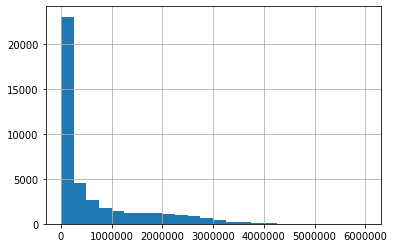

In [10]:
countsDf['count'].hist(bins=[250000*i for i in range(25)])

The distribution is heavily skewed (right tailed)... I may need to do some transformation on this variable if I need to work with it later on. 

# Q1

### 1- Classify each video into the following buckets:####<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Hot" - means trending up. These videos are candidates to be shown. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; o  "Everything else" - these videos won't be shown. <br>

### Solution logic:

One attribute for calssifying the movies is the trend. So first I need to determine what do "Trend Up" and "Flatness" mean? I note that the view counts spread widely across various videos (from the describtion above). As such, for trend assessment, in order to maintain relativeness to be able to compare videos based on this criteria, I can look at the rate of change.<br>
There are a couple of ways to do this. Either directly calculate the evareg rate of change in each time series, or I can fit a linear line to the logarithm of the viewing counts and consider the slope as an approximate of the average rate of change. I decide to go with the latter as a popular way to indicate trend in time series. 

As for popularity, it is more straightforward, and I can look at statistics of the count itself. I can choose minimum or mean/median. I will go with median as minimum could be faulty in case that in one single day a movie is not viewed at all maybe simply due to technical issues. But indeed the movie could be still popular. Also, compared to mean, median is more robust against outliers.

### *Trend Analysis*

I need to group the data by video id and then generate a trend for each group (i.e. each video id). in order to fit a linear regression line trough the observations (=counts) within each group, I need to make sure the data is sorted based on date and then be able to fit a linear trend line. According to pandas groupby documents, it preserves order within observations of each group, so I first sort the data based on date, and then group on video ids. I can also leverage the 'agg' operation to map the trend calculation of the groupned data. <br>

In the same groupby statement, I calculate the median value for the counts as well (for popularity evaluation).

Below is the code for this two steps:

In [11]:
#fit a trend line (linear regression) to the logarithm of the time series values 
#and return the line slope as the trend indicator.
def getTrend(series):
    m, b = np.polyfit([i for i in range(len(series))], np.log(series), 1) 
    return m


countsDf.sort_values(['date'], inplace=True)   #sorting the time series
trendDf = countsDf.groupby("video_id")['count'].agg(trend=getTrend, 
                                                    median_count=np.median).reset_index()   #calculate trend and median
trendDf.head(10)

,video_id,trend,median_count
0,1,-0.138611,65907
1,2,-0.006330,1718352
2,3,0.012894,2247587
3,4,0.011313,2719547
4,5,-0.114482,388594
5,6,-0.169402,58520
6,7,-0.148929,236740
7,8,0.008080,2042499
8,9,0.007871,328
9,10,0.283766,5483


Now that I have the viewing trend values, I simply join the two datasets to get this value over to the original counts data.

In [12]:
countsDf = countsDf.merge(trendDf, on='video_id', how='left')
countsDf.head(10)

,video_id,count,date,trend,median_count
0,2576,1126807,2015-01-01,-0.114259,426702
1,492,1031016,2015-01-01,-0.145225,291287
2,2005,271,2015-01-01,-0.019882,244
3,50,351,2015-01-01,-0.020956,354
4,1606,458361,2015-01-01,-0.021848,392927
5,675,2939384,2015-01-01,-0.016348,2306097
6,92,18,2015-01-01,-0.068021,12
7,1188,1511385,2015-01-01,0.010545,1593007
8,1039,170,2015-01-01,-0.025712,137
9,2569,225167,2015-01-01,-0.123432,128237


So now back to the question of what is "trend up" and what is "flatness"? before making decisions, let me have a look at the distribution of newly created trend and popularity attributes.

First I look at the distribution information for the viewing trends across different id's

In [13]:
trendDf.describe()

,video_id,trend,median_count
count,2785.000000,2785.000000,2.785000e+03
mean,1498.673250,0.006337,5.950780e+05
std,864.239687,0.165809,8.666992e+05
min,1.000000,-0.254783,5.000000e+00
25%,754.000000,-0.121751,9.439000e+03
50%,1492.000000,-0.011448,1.738610e+05
75%,2236.000000,0.014362,7.733720e+05
max,3000.000000,0.456402,4.235253e+06


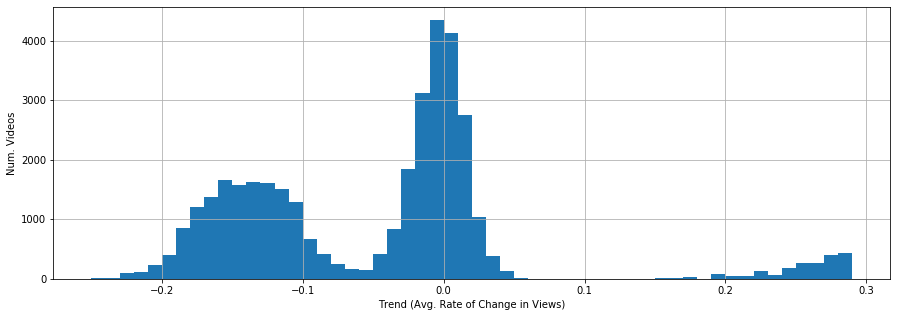

In [14]:
#visualise trend distribution:
countsDf['trend'].hist(bins=[0.01*i for i in range(-25, 30)], figsize=(15,5))
plt.xlabel("Trend (Avg. Rate of Change in Views)")
plt.ylabel("Num. Videos")
plt.show()

Promising...looks like a separable distribution where highly upward trend is easily separable from flat trend and downward trend.

Now, I visualise the distribution of videos based on both newly created attibutes for trend and popularity:

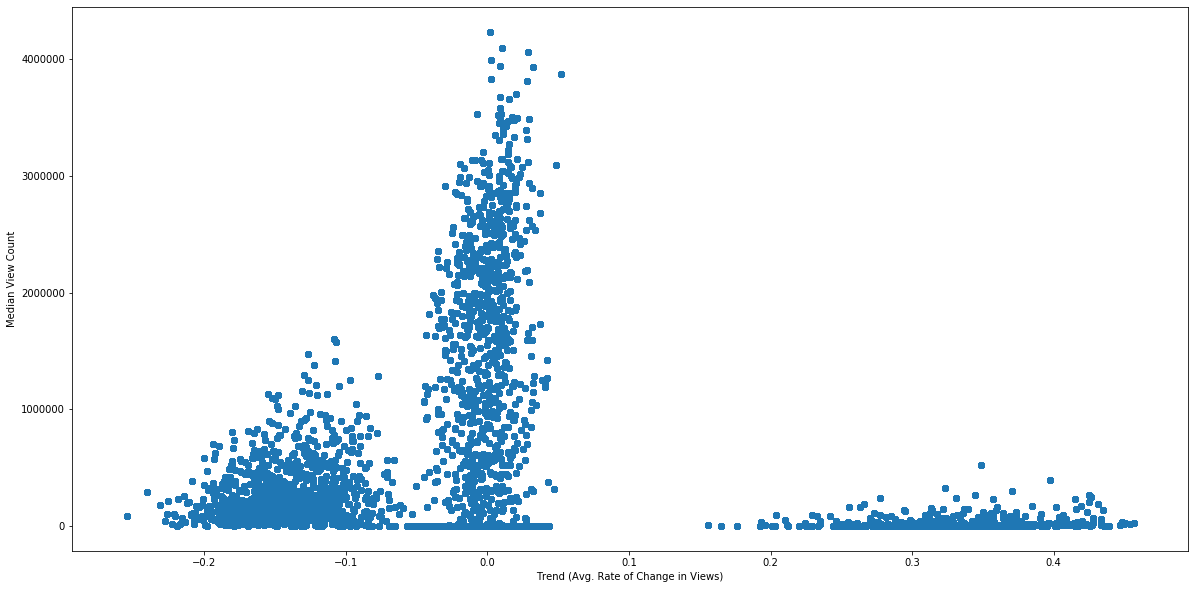

In [15]:
plt.figure(figsize=(20,10))
plt.scatter(countsDf['trend'], countsDf['median_count'])
plt.xlabel("Trend (Avg. Rate of Change in Views)")
plt.ylabel("Median View Count")
plt.show()

Nice... a few insights here:<br> 
1) the seperation is dominated by the trend; <br>
2) the highly upward-trending videos are relatively small in median viewing counts, but given the very sharp increaing rate they are being viewed at (viral?!), they have a big potential to reach high viewing counts in the future, so it is reasonable to include them in the recommendation; <br>
3)some of the highly viewed videos are also showing some upware trend (not as high as the right bottom corner); but with a right minimum criteria, they will be captured as part of "Stable & Popular" videos and will still be candidates to be recommended, so we are not missing on them.

### *Labeling strategy*:

I can now label the Hot videos using the trend. As descried in the business question, "Hot" mean trending up, i.e. positive rate of change. I think in a business context we actually can introduce a minimum criteria for a video to be identified as "Hot". If a slope is large enough for the video to be identified as hot, as opposed to those that have some slight up and downs (which might still show a small positive slope). This is indeed a parameter and can be set based on the business objectives or experimentations. The bigger this tolerance, the more likely we are missing on videos that can be potentially hot and views are actually interested to watch if get the recommendation. Lower values may mean that we allow for some not hot videos to be recommended to the user. While this might seems harmless, it might negatively impact the impression of the customer about the efficiency of our smart recommendation technology. And with the competition in market, this might mean losing customers.

Here, however, given the clear seperation that the normalise trend give us, we can introduce the hotness criteria easily from the above scatter plot. As for flatness, I can allow a marginal negative slope to be considered as flat.

As for the popularity, in the absence of further business context, I select a relative measure: <br>
I define "very high view count" to be anything more than the 9th quantile of all "median view counts" across all videos.<br>

One other thing to note is, as both "Hot" (trend up) and "Stable & Popular" (flat and very high) videos are going to be candidates to be shown, basically only videos that are trending down AND not very high demand will be filtered; As I need to identify both "Trend Up" and "Flat", I decide to choose relative criteria for these as below:

In [16]:
print("Assumptions in this analysis: ")
HOTNESS_MIN_TOL = 0.1   #as observed in the above visualisation (x-axis)
print(f"Trend up means slope > {HOTNESS_MIN_TOL}")
FLATNESS_MIN_TOL = -0.001  #small tolerance for flatness
print(f"Flatness means slope in range [{FLATNESS_MIN_TOL}, {HOTNESS_MIN_TOL}]")

#How high is very high for video counts? I think it is a relative thing, so in the absence of more business context, 
#I choose the relevant parameter as below:
POPULARITY_MIN_TOL = trendDf['median_count'].quantile(0.9)
print(f"Minimum popularity: {POPULARITY_MIN_TOL}")

Assumptions in this analysis: 
Trend up means slope > 0.1
Flatness means slope in range [-0.001, 0.1]
Minimum popularity: 2093595.9999999995


With the above parameters chosen, we are basically after the videos falling in the first quadrant of the plot below as candidates to be shown as recommendations.

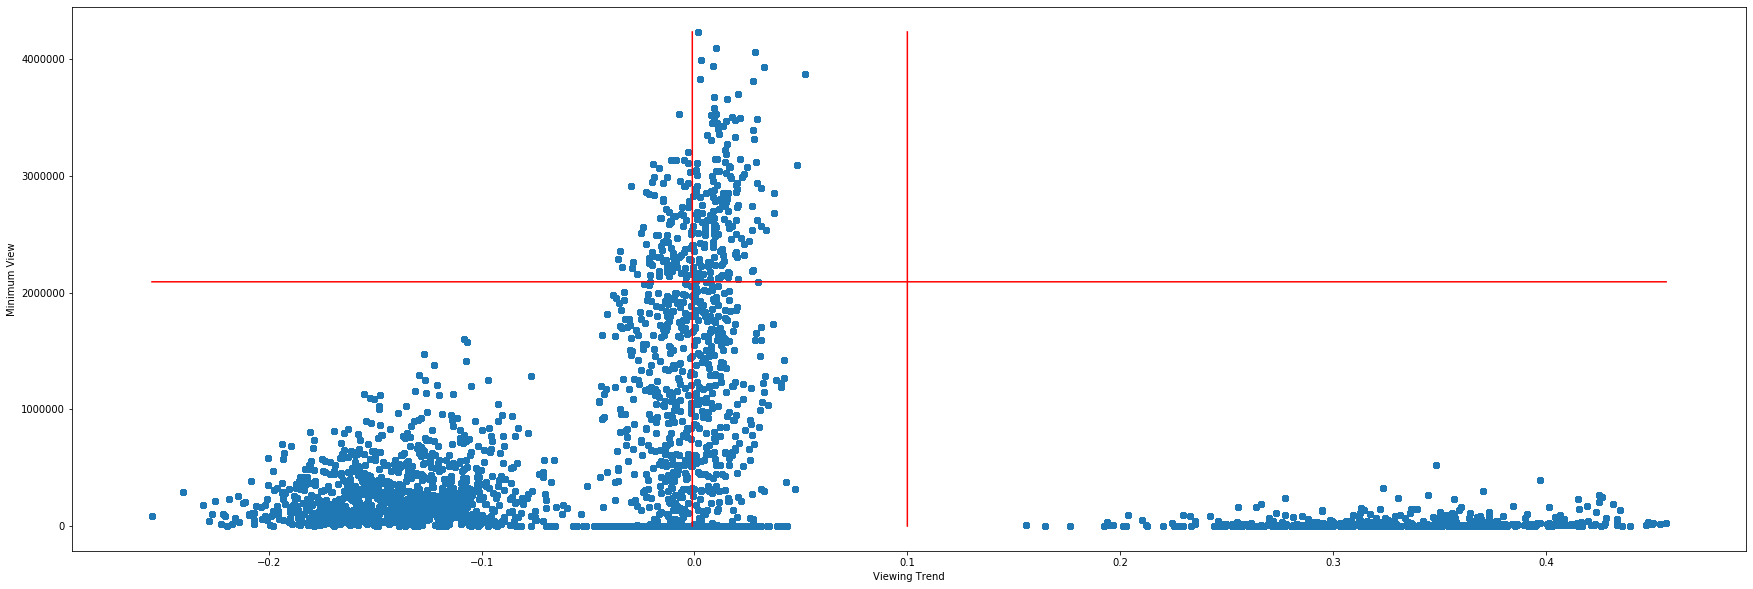

In [17]:
plt.figure(figsize=(30,10))
plt.scatter(countsDf['trend'], countsDf['median_count'])
ver = countsDf['median_count'].sort_values()
hor = countsDf['trend'].sort_values()
plt.plot([HOTNESS_MIN_TOL for i in range(len(ver))], list(ver), c='red')
plt.plot([FLATNESS_MIN_TOL for i in range(len(ver))], list(ver), c='red')
plt.plot(list(hor), [POPULARITY_MIN_TOL for i in range(len(hor))], c='red')
plt.xlabel("Viewing Trend")
plt.ylabel("Minimum View")
plt.show()

In [18]:
#create labels based on the criteria introduced above:
def getLabel(row):
    if row['trend'] > HOTNESS_MIN_TOL:
        return 2
    elif row['trend'] > FLATNESS_MIN_TOL and row['median_count'] > POPULARITY_MIN_TOL:
        return 1
    else:
        return 0
        
countsDf['label'] = countsDf.apply(getLabel, axis=1)  #apply labels to the data in a separate column
countsDf.head()

,video_id,count,date,trend,median_count,label
0,2576,1126807,2015-01-01,-0.114259,426702,0
1,492,1031016,2015-01-01,-0.145225,291287,0
2,2005,271,2015-01-01,-0.019882,244,0
3,50,351,2015-01-01,-0.020956,354,0
4,1606,458361,2015-01-01,-0.021848,392927,0


Below, I clearly visulaise what data points were identified as "Hot" (Yellow) vs "Stable & Popular" (Green) vs "Everything Else" (purple).

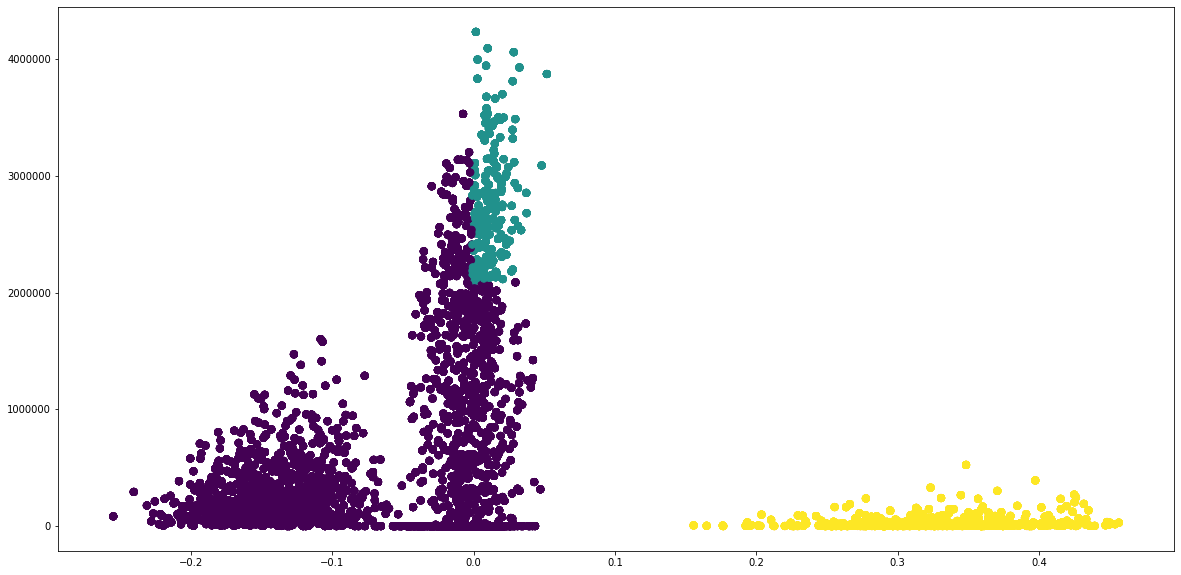

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(countsDf['trend'], countsDf['median_count'], c = countsDf['label'].astype(float), s=50)

And below is the numerical statistics on these labeling:

In [20]:
countsDf['label'] = countsDf['label'].map({0:"EE", 1:"SP", 2:"Hot"})
numHot = countsDf[countsDf['label']=="Hot"].shape[0]
numSP = countsDf[countsDf['label']=="SP"].shape[0]
total = countsDf.shape[0]
print("Among total of %d videos, %d (=%4.2f percent) Hot and %d (=%4.2f percent) Stable & Popular videos are identified"%(total, numHot, numHot*100/total, numSP, numSP*100/total))

Among total of 41775 videos, 7500 (=17.95 percent) Hot and 2655 (=6.36 percent) Stable & Popular videos are identified


# Q2

### 2- What are the main characteristics of the "hot videos"?

### Solution logic:

Now that I have labelled the data, I will bring in the video features data and merge it with the labeled data. Then I will analyse various features vs labels to see if I can find meaningful correlations/associations between features and labels. I will use multiple techniques to investigate correlations/associations including univariate analysis (visualisation, conditional probabilities etc) and multibarriate analysis using tree-based models. 

First lets read in the features data and sort it based on upload date

In [21]:
featuresDf = pd.read_csv("../data/video_features.csv", parse_dates=['video_upload_date'])
featuresDf.sort_values('video_upload_date', inplace=True)

Then, lets merge together the label data to features data. Before that, I am curious to know about the vidoes on both datasets:

In [22]:
set(countsDf['video_id'].unique()) == set(featuresDf['video_id'].unique())

True

In [23]:
combinedDf = featuresDf.merge(countsDf, how='outer', on='video_id')
print(combinedDf.shape)
combinedDf.head(10)

(41775, 10)


,video_id,video_length,video_language,video_upload_date,video_quality,count,date,trend,median_count,label
0,1812,1748,Fr,2014-12-02,1080p,313181,2015-01-01,-0.160359,140155,EE
1,1812,1748,Fr,2014-12-02,1080p,317564,2015-01-02,-0.160359,140155,EE
2,1812,1748,Fr,2014-12-02,1080p,328656,2015-01-03,-0.160359,140155,EE
3,1812,1748,Fr,2014-12-02,1080p,290249,2015-01-04,-0.160359,140155,EE
4,1812,1748,Fr,2014-12-02,1080p,217678,2015-01-05,-0.160359,140155,EE
5,1812,1748,Fr,2014-12-02,1080p,181824,2015-01-06,-0.160359,140155,EE
6,1812,1748,Fr,2014-12-02,1080p,142204,2015-01-07,-0.160359,140155,EE
7,1812,1748,Fr,2014-12-02,1080p,140155,2015-01-08,-0.160359,140155,EE
8,1812,1748,Fr,2014-12-02,1080p,124936,2015-01-09,-0.160359,140155,EE
9,1812,1748,Fr,2014-12-02,1080p,110113,2015-01-10,-0.160359,140155,EE


I now perform some univariate analysis between various features and the labels.

### *Feature: Video length*

This is a countinuos numeric value, so I would use both box plot to check on the distribution. 

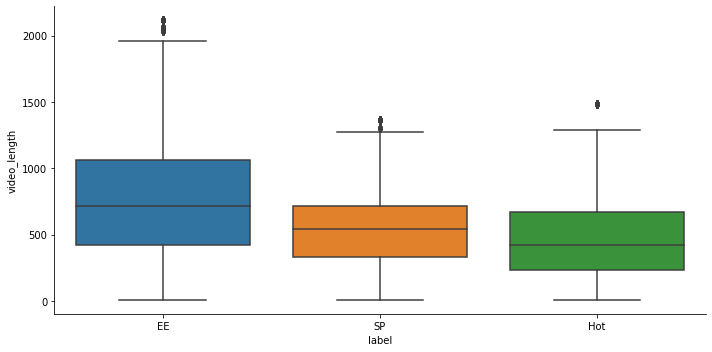

In [24]:
#box plot to check on the mutual distiburion of labels and vide lengths.
sns.catplot(x='label', y='video_length', data=combinedDf, kind='box', aspect=2)

Interesting finding... It seems like "Hot" videos are more associated with shorter videos. 

### *Feature: Video quality*

This is a categorical variable, but is ordinal, i.e. the categories represent the order of the quality of the video. As such, before analysis, I will encode this variable: that is, I create numerical values representing these categories while maintaining the order. I use this mapping strategy to do so: {'240p':1, '360p':1, '480p':2, '720p':3, '1080p':4}

In [25]:
combinedDf['video_quality'] = combinedDf['video_quality'].map({'240p':0, '360p':1, '480p':2, '720p':3, '1080p':4})

After this mapping, I first look at the count distribution across various video qualities. This is to show me any significant bias in favour of/against any of the video qualities, which may results in biased results/conclusions. 

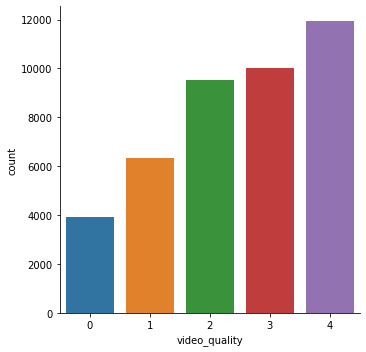

In [26]:
sns.catplot(x='video_quality', data=combinedDf, kind='count')

It is seen that there are more higher quality videos among the samples than lower quality ones. I have to make sure that my analysis take this into consideration for drawing any conclusions. 

One way that can lead to low-biased conslusion in such case is to look at the conditional probabilities. In other words, we want to know more about "Hot" videos. So, I would like to find out if I know the video quality, is it then more or less likely for that video to be "Hot"? i.e. probability("Hot" given quality is X). 

To go about such analysis, I can look at the counts matrix as below:

In [27]:
combinedDf.groupby(['label','video_quality']).size().unstack(fill_value=0)

video_quality,0,1,2,3,4
label,,,,,
EE,2985,4935,7530,7110,9060
Hot,645,1050,1350,2400,2055
SP,300,360,645,525,825


Or more precisely, calculate the conditional probabilities as described above in the following manner:

In [28]:
#conditional probabilities
qualityProbs = combinedDf.groupby('video_quality').size().div(len(combinedDf))
combinedDf.groupby(['label', 'video_quality']).size().div(len(combinedDf)).div(qualityProbs, axis=0, level='video_quality')

label  video_quality
EE     0                0.759542
       1                0.777778
       2                0.790551
       3                0.708520
       4                0.758794
Hot    0                0.164122
       1                0.165485
       2                0.141732
       3                0.239163
       4                0.172111
SP     0                0.076336
       1                0.056738
       2                0.067717
       3                0.052317
       4                0.069095
dtype: float64

Another interesting finding.... <br>
Looking at the conditional probabilities, I can see that among all video qualities, quality 3 (=720p) gives me the highest probability for the video to be "Hot" while quality 2 (=480p) give the least. 


### *Video language*

Next up is the video language. This is a categorical variable which in first glance may not be ordinal, i.e. the categories may not preserve a natural order. However, in the context of this problem, as we are investigating the effect of video language of its popularity, then I believe the language can be ordinal, because they can be ordered in terms of the number of speakers (not necessarily native) of the language worldwide. I believe this can have an effect on the popularity of the video.

As such, I use the information in wikipedia (https://en.wikipedia.org/wiki/List_of_languages_by_total_number_of_speakers) to map and order the languages in this dataset based on the number of total speakers of that language worldwide - I note that "other" could be anything and therefore in totall would be more than all other languages.
{'De':0, 'Fr':1, 'Es':2, 'Cn':3, 'En':4, 'other':5}

In [29]:
combinedDf['video_language'] = combinedDf['video_language'].map({'De':0, 'Fr':1, 'Es':2, 'Cn':3, 'En':4, 'Other':5})

After this mapping, I first look at the count distribution across various languages, to check for possible sampling bias. 

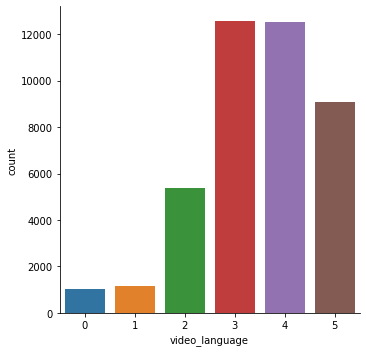

In [30]:
sns.catplot(x='video_language', data=combinedDf, kind='count')

It is seen that there are different number of languages among samples, some very high and some very low. I have to make sure that my analysis take this into consideration for drawing any conclusions. 

Again I go anbout this by looking at the conditional probabilities. In other words, I would like to find out if I know the language of a video, is it then more or less likely for that video to be "Hot"? i.e. probability("Hot" given language is X). 

To go about such analysis, I can look at the counts matrix as below:

In [31]:
combinedDf.groupby(['label','video_language']).size().unstack(fill_value=0)

video_language,0,1,2,3,4,5
label,,,,,,
EE,840,870,4200,9270,8940,7500
Hot,90,240,870,2250,2760,1290
SP,105,60,300,1050,840,300


In [32]:
#conditional probabilities
qualityProbs = combinedDf.groupby('video_language').size().div(len(combinedDf))
combinedDf.groupby(['label', 'video_language']).size().div(len(combinedDf)).div(qualityProbs, axis=0, level='video_language')

label  video_language
EE     0                 0.811594
       1                 0.743590
       2                 0.782123
       3                 0.737470
       4                 0.712919
       5                 0.825083
Hot    0                 0.086957
       1                 0.205128
       2                 0.162011
       3                 0.178998
       4                 0.220096
       5                 0.141914
SP     0                 0.101449
       1                 0.051282
       2                 0.055866
       3                 0.083532
       4                 0.066986
       5                 0.033003
dtype: float64

Another interesting finding.... <br>
Looking at the conditional probabilities, I can see that among all languages, language 4 (=English) gives me the highest probability for the video to be "Hot", followed marginally by French. while language 0 (German) gives the least. For me, it is quaite expected for English to be on top, but French being the second highest is quaite an interesting finding...  

### *Video upload date*

Another given attribute for the videos is the date of upload. It can be quite an interesting feature... <br>



As seen in the EDA section, all videos are being analysed over an identical period with no gap (15 days from 1 to 15 Jan 2015).
Given the notes above, I decided to create a new feature based on the upload date, which shows the how long before the start of the period the video was uploaded? 

First, I want to know what range of upload dates I am dealing with:

In [33]:
combinedDf['video_upload_date'].unique()

array(['2014-12-02T00:00:00.000000000', '2014-12-03T00:00:00.000000000',
       '2014-12-04T00:00:00.000000000', '2014-12-05T00:00:00.000000000',
       '2014-12-06T00:00:00.000000000', '2014-12-07T00:00:00.000000000',
       '2014-12-08T00:00:00.000000000', '2014-12-09T00:00:00.000000000',
       '2014-12-10T00:00:00.000000000', '2014-12-11T00:00:00.000000000',
       '2014-12-12T00:00:00.000000000', '2014-12-13T00:00:00.000000000',
       '2014-12-14T00:00:00.000000000', '2014-12-15T00:00:00.000000000',
       '2014-12-16T00:00:00.000000000', '2014-12-17T00:00:00.000000000',
       '2014-12-18T00:00:00.000000000', '2014-12-19T00:00:00.000000000',
       '2014-12-20T00:00:00.000000000', '2014-12-21T00:00:00.000000000',
       '2014-12-22T00:00:00.000000000', '2014-12-23T00:00:00.000000000',
       '2014-12-24T00:00:00.000000000'], dtype='datetime64[ns]')

I initially thought perhaps it would be interesting to see the relation between "age of video = number of days since the upload of the video" vs "counts". Let me create this feature and have a play around the data:

In [34]:
combinedDf['days_since_upload'] = combinedDf.apply(lambda r: (r['date']-r['video_upload_date']).days, axis=1)
combinedDf.head()

,video_id,video_length,video_language,video_upload_date,video_quality,count,date,trend,median_count,label,days_since_upload
0,1812,1748,1,2014-12-02,4,313181,2015-01-01,-0.160359,140155,EE,30
1,1812,1748,1,2014-12-02,4,317564,2015-01-02,-0.160359,140155,EE,31
2,1812,1748,1,2014-12-02,4,328656,2015-01-03,-0.160359,140155,EE,32
3,1812,1748,1,2014-12-02,4,290249,2015-01-04,-0.160359,140155,EE,33
4,1812,1748,1,2014-12-02,4,217678,2015-01-05,-0.160359,140155,EE,34


Now I want to look at the relation between age of the video and view counts below:

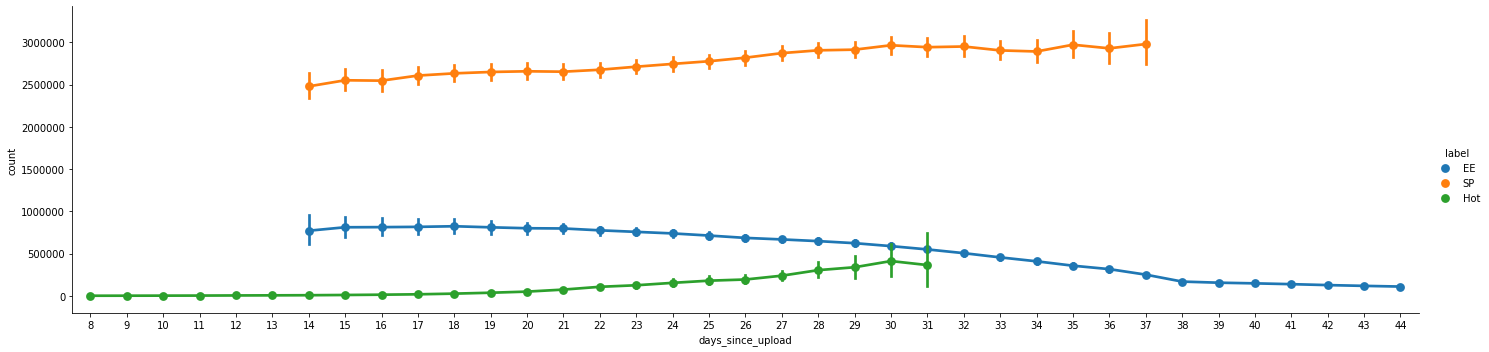

In [35]:
sns.catplot(x='days_since_upload', y='count', hue='label', data=combinedDf, kind='point', aspect=4)

I can see that overal, for both "Hot" and "Popular & Stable" videos, the older they get, the more view daily view counts (not accumulative) they get whereas the "EE" videos are seeing a declining trend. However, this could not be a complete picture, because we are limiting the view to 15 days period, and cannot see if the counts videos are going to continue to grow for "Hot" and "SP" videos or if (when) it would plateau or even drop. This takes me back to check the problem in hand and the labeling logic.

I note that here as per the logic of labeling the data, "Hot"ness is defined over a period of 15 days; In other words, the business problem (and the product) is about evaluating the potential of a video to become "Hot" over a period, using the information available at the start of that period, as opposed to progressively at each point of time (on each day) being able to predict the counts in next day, using the previous counts. The latter is obviously a valid model (forecasting) but is for a different product.

Given these observations, I decided to create another feature that is more suitable for the business problem here: the age of the video at the start of analysis (target) period.

In [36]:
import datetime as dt
combinedDf = combinedDf.drop(['days_since_upload'], axis=1)
combinedDf['age_at_period_start'] = combinedDf.apply(lambda r: (dt.datetime(2015,1,1)-r['video_upload_date']).days, axis=1)
combinedDf['age_at_period_start'].unique()

array([30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8], dtype=int64)

This is a numerical feature and I want to explore its correlation with the Label using the box plot. Before doing that, I also look at count of various video ages among the data.

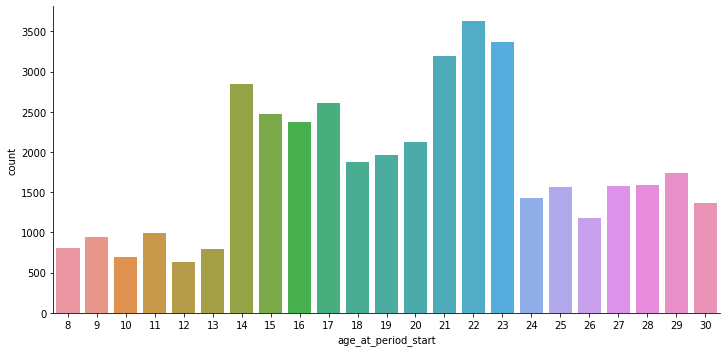

In [37]:
sns.catplot(x='age_at_period_start', data=combinedDf, kind='count', aspect=2)

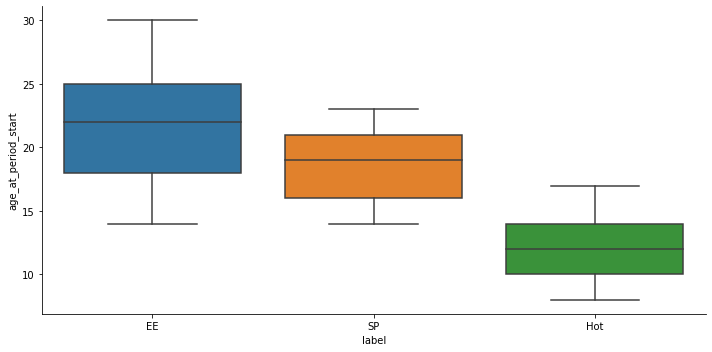

In [38]:
sns.catplot(x='label', y='age_at_period_start', data=combinedDf, kind='box', aspect=2)

Another piece of finding...<br>
An obvious correlation can be seen here; "Hot" videos are quite clearly isolated from other labels based on the age of video.  Hot videos are more likely to be among younger videos (more recently uploaded) specially below 15 days of age at the start of the period.

At this stage, after running some univariate analysis (i.e. associateion of each feature to the target variabel "label") and obtaining some interesting insights, I want to run a multivariate analysis. The reason is although univariate analysis can bring in insights for business decisions, sometimes it can not show (or even it can hide) the underlying truth. Because univariate analysis only looks at the impact of each feature on the target variabel in isolation from other features, it may not clearly demonstrate multivariate impacts. For example, we might see that video quality of 720p is more likely to get hot vs other qualities, but what if in the data we are looking at 720p videos mostly contain English language videos, and the effect that we are seeing is actually have something to do with the language rather than the quality! This is true for all other features. As such, a multivariate analysis can at the same time look at relative impact of features on the target variable and give us a more clear and accurate picture.

A very useful way to do multivariate analysis in a quick and robust way is to use tree-based models, and check the feature importances (i.e. the impact of various features in building a predictive tree model), because in fitting a tree, at each branching node, the decision is made by considering the impacts of all the features not each in isolation. This will give us what we were after. 

I can build a model three labels: "Hot", "SP" and "EE". But because the business question is only about the "Hot videos, I create a binary target variable for the label: "Hot" vs "not Hot". 

## Multivariate Analysis: Tree-based feature importance

### Hot vs Others (Binary classification)

First I group the data on the features and label in a new dataframe and then relabel the target variable to include only two classes.

In [39]:
data = combinedDf.groupby(['label', 'video_length', 'video_language', 'video_quality', 'age_at_period_start']).max().reset_index()
data = data[['label', 'video_length', 'video_language', 'video_quality', 'age_at_period_start']]
data['label'] = data['label'].map({"Hot":1, "SP":0, "EE":0})
data.head()

,label,video_length,video_language,video_quality,age_at_period_start
0,0,10,4,3,21
1,0,10,5,1,30
2,0,10,5,2,28
3,0,15,3,1,17
4,0,15,3,1,23


Here we are dealing with a binary classification. <br>
As I am dealing with an unbalaced dataset here (~25% of totals are 1 and ~75% is 0), I choose the metric "f1_score", that creates a balance between precision and recall.  Later I will also investigate the cofusion matrix as well.

I use the utilities provided by sklearn package.  

I note that as tree-based models are not sesitive to scaling of the predictors, I do not need to scale the feature matrix. Hence, I only create train and test (70% train and 30% test) sets to check the performance of the model and also find out about feature importances.

In [40]:
from sklearn.model_selection import train_test_split
#splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size=0.3, random_state=111)

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

est = DecisionTreeClassifier(random_state=0)  #create an instance of DT classifier - set random state for reproducability
est.fit(x_train, y_train)                     #fitting the classifier to the train data 
y_pred = est.predict(x_test)                  #using the fitted model to predict labels for test data 
print("Accuracy = ", accuracy_score(y_test, y_pred))    #what is the accuracy score?
print("F1 score = ", f1_score(y_test, y_pred))          #what is the f1 score?
confusion_matrix(y_test, y_pred)                        #let's have a look at the confusion matrix

Accuracy =  0.9230769230769231
F1 score =  0.7837837837837838


array([[652,  35],
       [ 29, 116]], dtype=int64)

I can see from the confusion matrix that the prediction power is not very high, but reasonably high. The recall power is a little bit better than precision, but in general I believe it is a reasonable model for the purpose of finding out about feature importances. 

I note that if such a model were to be productionise, there are ways to improve the accuracy. I would definitely look at random forest as well as gradient boosting tree models. Plus, I would also do paramter tuning as well as maybe data resampling (to tackle imbalance dataset).

However, for the purpose of the objective here (feature importances) I believe the current model is sufficient.

## *Feature importance*

So now I will look at feature importances from the tree model, first in numbers and then visualised.

In [42]:
pd.Series(est.feature_importances_, index=list(x_train))

video_length           0.217259
video_language         0.044272
video_quality          0.034310
age_at_period_start    0.704159
dtype: float64

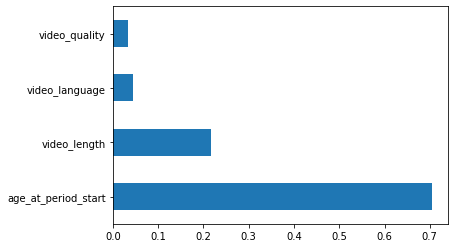

In [43]:
(pd.Series(est.feature_importances_, index=list(x_train)).nlargest(5).plot(kind='barh'))

We can see clearly see the importance of various features in the prediciton of the label. "age_at_period_start" clearly dominates the importance for the prediciton of labels, and it explains about 70% of the decision made to branch the tree. In the second place is the "video_length" explaining about 20% of the decisions. The other two features are quite close, with "video_language" being slightly more important that "video_quality".  


*But how would the variation within each feature impact the prediction of target?*

Another useful utility in sklearn is partial dependence analysis. This analysis can illustrate the marginal impact of one or more features the on the prediction of the target variable. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. 

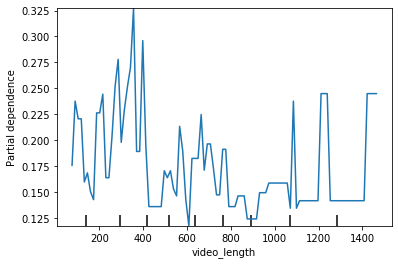

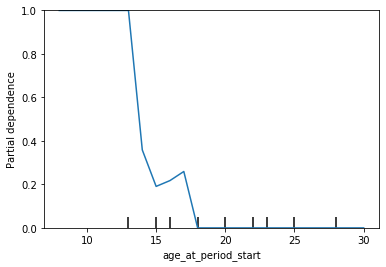

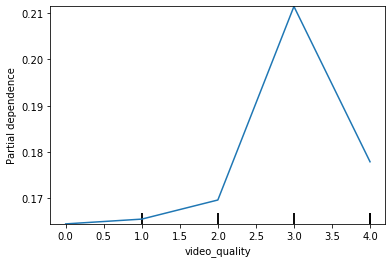

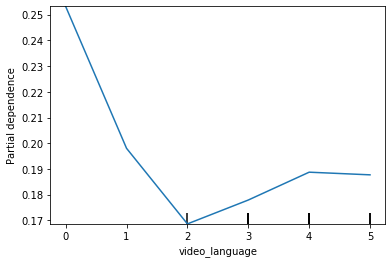

In [44]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(est, x_train, feature_names=list(x_train), 
                        features=['video_length'], 
                        target=1) 

plot_partial_dependence(est, x_train, feature_names=list(x_train), 
                        features=['age_at_period_start'], 
                        target=1) 

plot_partial_dependence(est, x_train, feature_names=list(x_train), 
                        features=['video_quality'], 
                        target=1) 

plot_partial_dependence(est, x_train, feature_names=list(x_train), 
                        features=['video_language'], 
                        target=1) 

As seen from the above plots, first of all a look across four plots and the partial dependence of the four features confirms the feature importances visualised above.

Moreover, we csan see per feature, how the values impact the predictions: 
1- video_length: the relation is quite complex, but it can be seen that shorter videos have higher dependence to being hot but overal there are some irregularities in the dependences. Mostly consistent with what we conslude from univariate analysis.

2- age_at_period_start: very clear that more recently uploaded videos have way more impact. But for videos that are older than 17.5 (?), there is no dependence, which would mean none of the videos older than 17.5 days are hot! Overal, the finding of our univariate analysis is confirmed.

3- video_quality: it is clear the lower quality videos are less likely to be hot. However, super high quality (1080p) is not necessarily the highest likelihood (maybe because not it needs more data to be played out and 720p is offering the best comprimise between quality and data usage!). This confirms our finding in univariate analysis.

4- video_language: very interesting finding here, as it seems like languages "German" and "French" show higher dependence followed by English, Other languages, Chinese and Spanish. However, the differences are quite marginal.

## *Tree plot*:

I decided to plot the decision tree to enable further in how the model decides to classify data points. This could be useful especially to present to business experts as a way for them to better understand how the model arrives at the decisions and if it makes sense to them. 

In my work I have used this many times and have received good responds from the business experts about their undertsanding of the logic behind the model and how the decisions are made. I create the plot and save it to a .png image file for further use.

In [46]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
graph = Source( tree.export_graphviz(est, out_file=None, feature_names=x_train.columns))
graph.format = 'png'
graph.render('decision_tree', view=True)

# Q3

### 3- After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

### Approach 1 (low budget):

One approach to a solution: rules engine (static filter)

One way is creating a "Hotness" filter to better identify the videos that have potential to be a "Hot" video in a future period. This filter can very roughly mimic the decision tree build above. These videos then can be recommended to the users in a "Hot Recommendation" panel. I note that this is basically a static rules engine rather than a dynamic predictive model.

First of all, the business needs to decide on capacity of "Hot Recommendation" panel: maximum how many video to show? This may depend on the technical platform and limitations as well as some other user behavior study (perhaps A/B testing on a longer or shorter list?)
 
The logic of the filter is to take the videos through multi-leyered filter in a specific order until it reaches the capacity (lower or equal to the maximum capacity of the panel).
the ordered layers of "Hotness" filter are as follows:

1- Select vieos less than 14 days old.  

2- Select videos with duration between 200 and 500 seconds.

3- Select videos that are in one of these languages "English, French or German"

4- select videos with 720p quality.

5- If there more than capacity remaining, then randomly select videos from the remaining one to show in the "Hot Recommendation" panel.


### Approach 2 (medium budget) - My personal favourite:

More sophisticated than the previous one, I recommend developing and productioning a predictive model to identify the videos that are more likely to become "Hot" in a future period. The model can be build based on the features we investigated here in this study. The productinise process can be something like this:

Build a model to predict the likelihood of a video to become "Hot" over a coming period (for example here our period is first 15 days of January). (Logstic Regression, or tree-based models can be used to predict probabilities not just a label)

I note that the "Stable & Popular" videos must have been through a "getting Hot" journey during a period prior to the analysis period where that have reached a "Stable & Popular" status. So form this point of view, the product can be used costantly to repredict the "Hotness" pontetial at a more granualr level, for example daily. 

As the videos getting analysed by this model, we also keep an eye on the daily counts and as soon as the viewing counts satisfy "Stable and Popular criteria" as introduced in the labeling section, we move them to a separate panel, maybe the "Stable & Popualr Recommendation" panel and remove them from the hotness prediction dataset. We continue observing the daily viewing counts and eventually move them out of the recommendations, and to "Everything Else" bucket, if and when they are becoming less popular as compared to the popularity criteria. 

#### *How the solution process works:*

#Day 0$: Run the model on a all videos available in the database (except the ones that are already determined to be "Stable & Popular" based on the criteria introduced in the labeling section; these can be recommended in a different panel) and predict the probabilities of getting "Hot". Choose the first "n (= panel capacity)" with the highest probabilities and show them in the recommendation panel (if a tie, choose randomly). 

$Day i (for i > 0)$: Run the model on all newly uploaded videos (since previous model run in Day i-1) plus the current "n" recommended movies in "Hot" panel and predict probabilities. Choose the first "n (= panel capacity)" with the highest probabilities and show them in the recommendation panel (if a tie, choose randomly).

$Every 15 days$: Evaluate the "Stable and Popular" criteria on all videos and if any video found to fit the meet the criteria, remove it from the daily analysis and enter it in the another recommendation panel.

$Every X weeks$ *(this needs to be designed based on the avertage volumn of daily new videos, so maybe every week or all the way up to every few months; as per this study it could be every 6 weeks!)*: Collect the videos uploaded in the past X weeks, relabel them based on the labeling logic above and retrain the model and always use the most recently retrained model for daily predictions. This way we hope that unforseen changes in user behaviour and taste can be captutred by this model. 